In [2]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)


In [3]:
import sys
import glob, os

# remove warnings
import warnings
warnings.filterwarnings('ignore')

from pyprojroot import here

# Add the project root to sys.path
sys.path.append(str(here()))

from hspc.config import get_config
config = get_config()

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

from collections import Counter

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score

In [6]:

from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import numpy as np

In [7]:
import random
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
set_seed(42)

In [8]:
import tabpfn

In [9]:
from tabpfn import TabPFNClassifier as tbp
import shapiq

In [10]:
dataset = pd.read_csv(here() / config.data_interim / 'd_p_h_combined_unnormalized.csv')
dataset

,Gender,Age,WBC,Hgb,Hct,Platelet Ct,Neut Pct,Lymphocyte Abs,Mono Pct,Lymph Pct,Eos Pct,Mono Abs,Neut Abs,Eos Abs,Day 1 CD34 Absolute per uL,Count,lab
0,1,39,11.2,14.6,43.5,328.0,64.5,2.9,7.4,25.5,1.9,0.8,7.2,0.2,100.0,1,Dipersio
1,0,57,6.5,14.5,42.9,280.0,48.1,2.7,5.9,41.1,4.0,0.4,3.1,0.3,71.0,1,Dipersio
2,1,43,4.4,15.0,43.9,299.0,58.0,1.3,10.0,28.7,2.7,0.4,2.6,0.1,87.0,1,Dipersio
3,0,50,6.7,14.2,40.6,243.0,56.4,2.0,7.7,29.8,4.8,0.5,3.8,0.3,27.0,0,Dipersio
4,0,32,9.8,13.3,39.2,373.0,65.1,2.6,6.4,26.5,1.7,0.6,6.4,0.2,31.0,0,Dipersio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,1,23,31.3,13.5,39.4,257.0,76.0,2.8,8.0,9.0,1.0,2.5,23.8,0.3,58.0,1,hurwitz
1156,1,56,37.0,15.4,44.9,233.0,77.0,4.4,7.0,12.0,1.0,2.6,28.5,0.4,59.0,1,hurwitz
1157,0,25,51.9,13.8,40.7,265.0,64.0,7.3,9.0,14.0,1.0,4.7,33.2,0.5,56.0,1,hurwitz
1158,1,22,51.0,14.6,42.9,250.0,89.0,4.1,2.0,8.0,1.0,1.0,45.3,0.5,174.0,1,hurwitz


In [11]:
data = dataset.copy()

In [12]:
# change the lab value to Pre-Gcsf if value is Dipersio and Post-Gcsf if value is not Dipersio
data['lab'] = data['lab'].apply(lambda x: 'Pre-G-CSF' if x == 'Dipersio' else 'Post-G-CSF')

# change the gender value to Female if 0 and Male otherwise
data['Gender'] = data['Gender'].apply(lambda x: 'Female' if x == 0 else 'Male')

# change the Count value to Good if 1 and Poor otherwise
data['Count'] = data['Count'].apply(lambda x: 'Good' if x == 1 else 'Poor')

In [13]:
data

,Gender,Age,WBC,Hgb,Hct,Platelet Ct,Neut Pct,Lymphocyte Abs,Mono Pct,Lymph Pct,Eos Pct,Mono Abs,Neut Abs,Eos Abs,Day 1 CD34 Absolute per uL,Count,lab
0,Male,39,11.2,14.6,43.5,328.0,64.5,2.9,7.4,25.5,1.9,0.8,7.2,0.2,100.0,Good,Pre-G-CSF
1,Female,57,6.5,14.5,42.9,280.0,48.1,2.7,5.9,41.1,4.0,0.4,3.1,0.3,71.0,Good,Pre-G-CSF
2,Male,43,4.4,15.0,43.9,299.0,58.0,1.3,10.0,28.7,2.7,0.4,2.6,0.1,87.0,Good,Pre-G-CSF
3,Female,50,6.7,14.2,40.6,243.0,56.4,2.0,7.7,29.8,4.8,0.5,3.8,0.3,27.0,Poor,Pre-G-CSF
4,Female,32,9.8,13.3,39.2,373.0,65.1,2.6,6.4,26.5,1.7,0.6,6.4,0.2,31.0,Poor,Pre-G-CSF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,Male,23,31.3,13.5,39.4,257.0,76.0,2.8,8.0,9.0,1.0,2.5,23.8,0.3,58.0,Good,Post-G-CSF
1156,Male,56,37.0,15.4,44.9,233.0,77.0,4.4,7.0,12.0,1.0,2.6,28.5,0.4,59.0,Good,Post-G-CSF
1157,Female,25,51.9,13.8,40.7,265.0,64.0,7.3,9.0,14.0,1.0,4.7,33.2,0.5,56.0,Good,Post-G-CSF
1158,Male,22,51.0,14.6,42.9,250.0,89.0,4.1,2.0,8.0,1.0,1.0,45.3,0.5,174.0,Good,Post-G-CSF


In [39]:
colors = {0:'red', 1:'green'}

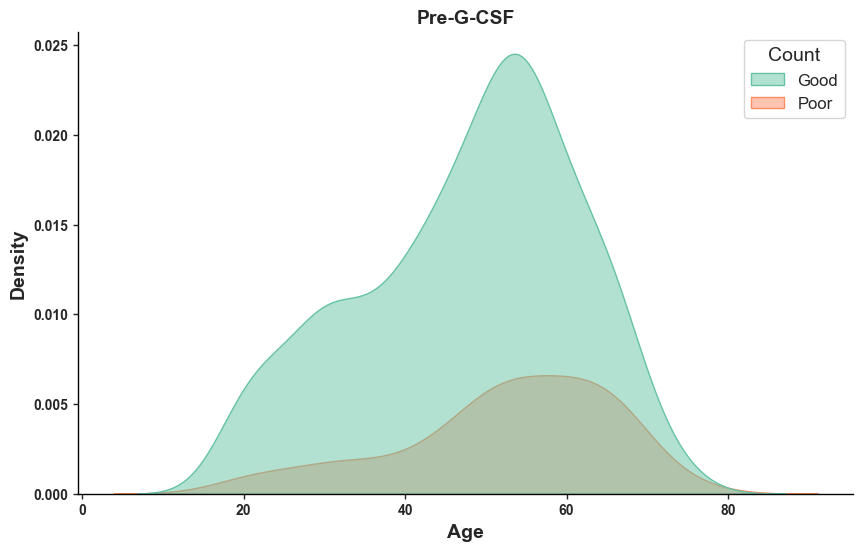

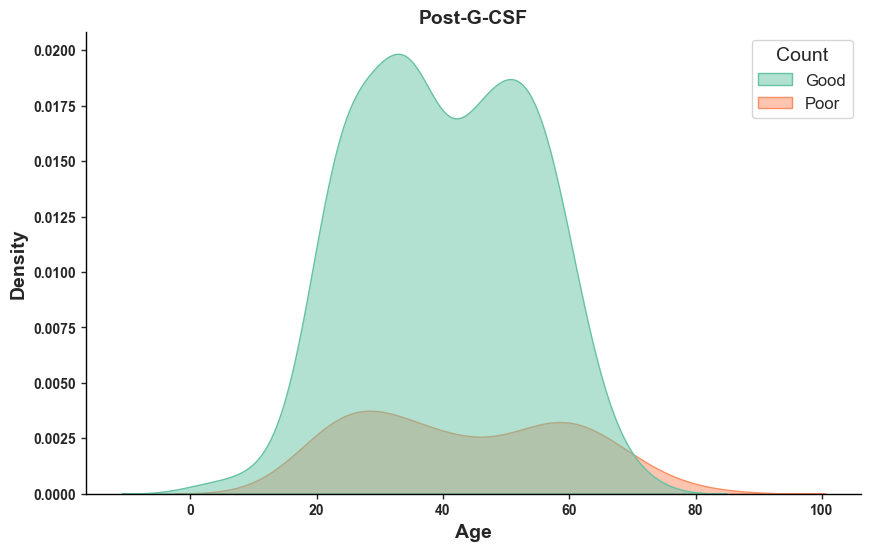

In [61]:
# plot a density plot of age hue by Count for pre Gcsf
plt.figure(figsize=(10, 6))
ax1 = sns.kdeplot(data=data[data['lab'] == 'Pre-G-CSF'], x='Age', hue='Count', fill=True, common_norm=True, alpha=0.5)
plt.title('Pre-G-CSF', fontsize=14, fontweight='bold', family='Arial')
plt.xlabel('Age', fontsize=14, fontweight='bold', family='Arial')
plt.ylabel('Density', fontsize=14, fontweight='bold', family='Arial')

# First call sns.despine() to remove top and right spines only
sns.despine(top=True, right=True, left=False, bottom=False)
plt.grid(False)

# THEN set spine properties and tick parameters
ax1.tick_params(axis='both', which='major', labelsize=12, width=1)
ax1.tick_params(axis='both', which='minor', labelsize=10, width=1)
ax1.spines['left'].set_linewidth(1)
ax1.spines['bottom'].set_linewidth(1)
ax1.spines['left'].set_color('black')
ax1.spines['bottom'].set_color('black')

# Ensure ticks are visible
ax1.tick_params(axis='x', which='major', bottom=True, top=False, direction='out')
ax1.tick_params(axis='y', which='major', left=True, right=False, direction='out')

# Fix the tick label setting
plt.setp(ax1.get_xticklabels(), fontsize=10, fontweight='bold', family='Arial')
plt.setp(ax1.get_yticklabels(), fontsize=10, fontweight='bold', family='Arial')

plt.savefig(here() / config.plots / 'descriptive_stat' / 'combined' / 'EDA' / f'kde_age_pregcsf.pdf', dpi=300, bbox_inches='tight')
plt.savefig(here() / config.plots / 'descriptive_stat' / 'combined' / 'EDA' / f'kde_age_pregcsf.png', dpi=500, bbox_inches='tight')
plt.show()

# Same fix for the second plot
plt.figure(figsize=(10, 6))
ax2 = sns.kdeplot(data=data[data['lab'] == 'Post-G-CSF'], x='Age', hue='Count', fill=True, common_norm=True, alpha=0.5)
plt.title('Post-G-CSF', fontsize=14, fontweight='bold', family='Arial')
plt.xlabel('Age', fontsize=14, fontweight='bold', family='Arial')
plt.ylabel('Density', fontsize=14, fontweight='bold', family='Arial')

# First call sns.despine()
sns.despine(top=True, right=True, left=False, bottom=False)
plt.grid(False)

# THEN set spine and tick properties
ax2.tick_params(axis='both', which='major', labelsize=12, width=1)
ax2.tick_params(axis='both', which='major', labelsize=12, width=1)
ax2.spines['left'].set_linewidth(1)
ax2.spines['bottom'].set_linewidth(1)
ax2.spines['left'].set_color('black')
ax2.spines['bottom'].set_color('black')

# Ensure ticks are visible
ax2.tick_params(axis='x', which='major', bottom=True, top=False, direction='out')
ax2.tick_params(axis='y', which='major', left=True, right=False, direction='out')

# Fix the tick label setting
plt.setp(ax2.get_xticklabels(), fontsize=10, fontweight='bold', family='Arial')
plt.setp(ax2.get_yticklabels(), fontsize=10, fontweight='bold', family='Arial')


plt.savefig(here() / config.plots / 'descriptive_stat' / 'combined' / 'EDA' / f'kde_age_post_gcsf.pdf', dpi=300, bbox_inches='tight')
plt.savefig(here() / config.plots / 'descriptive_stat' / 'combined' / 'EDA' / f'kde_age_post_gcsf.png', dpi=500, bbox_inches='tight')
plt.show()

In [58]:
print("Pre-G-CSF age range:", data[data['lab'] == 'Pre-G-CSF']['Age'].min(), "to", data[data['lab'] == 'Pre-G-CSF']['Age'].max())
print("Post-G-CSF age range:", data[data['lab'] == 'Post-G-CSF']['Age'].min(), "to", data[data['lab'] == 'Post-G-CSF']['Age'].max())

Pre-G-CSF age range: 18 to 77
Post-G-CSF age range: 2 to 79


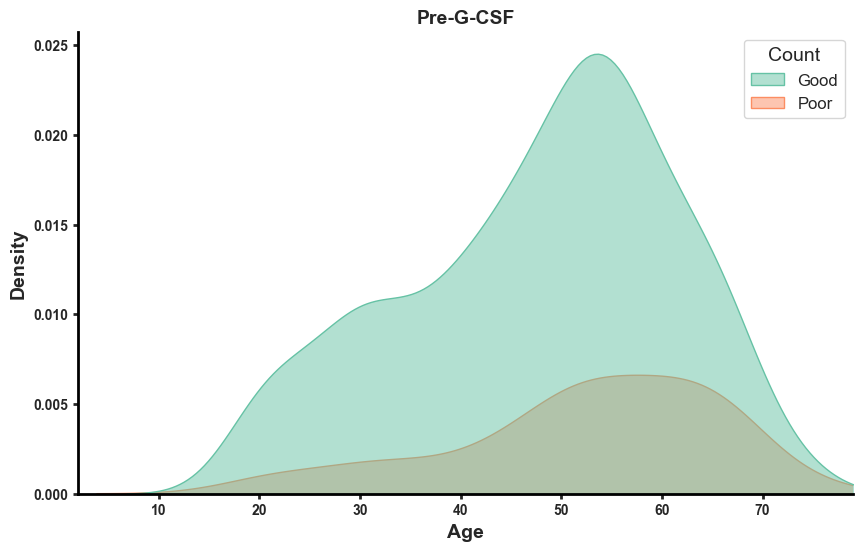

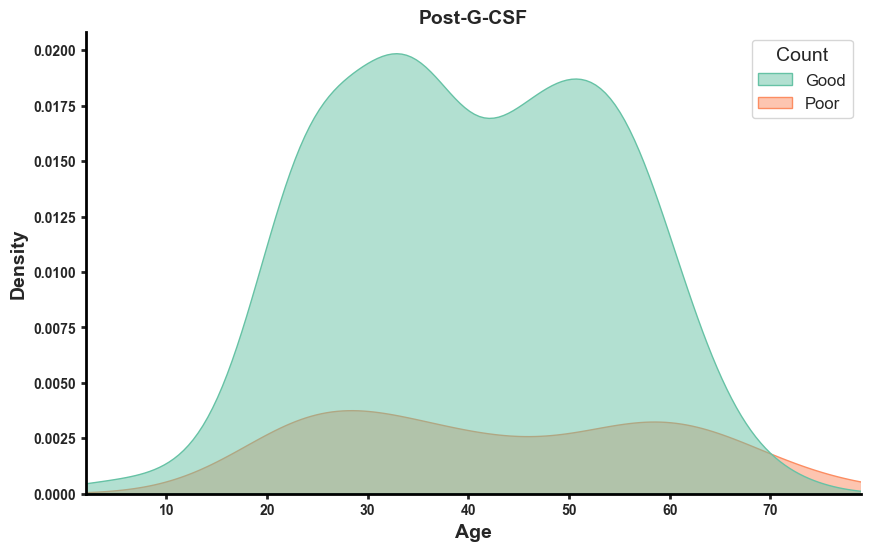

In [63]:

# Get the overall age range for consistent scaling
age_min = data['Age'].min()
age_max = data['Age'].max()

# plot a density plot of age hue by Count for pre Gcsf
plt.figure(figsize=(10, 6))
ax1 = sns.kdeplot(data=data[data['lab'] == 'Pre-G-CSF'], x='Age', hue='Count', fill=True, common_norm=True, alpha=0.5)
plt.xlim(age_min, age_max)  # Set consistent x-axis limits
plt.title('Pre-G-CSF', fontsize=14, fontweight='bold', family='Arial')
plt.xlabel('Age', fontsize=14, fontweight='bold', family='Arial')
plt.ylabel('Density', fontsize=14, fontweight='bold', family='Arial')

# First call sns.despine() to remove top and right spines only
sns.despine(top=True, right=True, left=False, bottom=False)
plt.grid(False)

# THEN set spine properties and tick parameters
ax1.tick_params(axis='both', which='major', labelsize=12, width=2)
ax1.tick_params(axis='both', which='minor', labelsize=10, width=2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_color('black')
ax1.spines['bottom'].set_color('black')

# Ensure ticks are visible
ax1.tick_params(axis='x', which='major', bottom=True, top=False, direction='out')
ax1.tick_params(axis='y', which='major', left=True, right=False, direction='out')

# Fix the tick label setting
plt.setp(ax1.get_xticklabels(), fontsize=10, fontweight='bold', family='Arial')
plt.setp(ax1.get_yticklabels(), fontsize=10, fontweight='bold', family='Arial')

# # Customize legend
# plt.legend(title='Count', 
#           prop={'size': 12, 'weight': 'bold', 'family': 'Arial'},
#           title_fontproperties={'size': 14, 'weight': 'bold', 'family': 'Arial'})

plt.savefig(here() / config.plots / 'descriptive_stat' / 'combined' / 'EDA' / f'kde_age_pregcsf.pdf', dpi=300, bbox_inches='tight')
plt.savefig(here() / config.plots / 'descriptive_stat' / 'combined' / 'EDA' / f'kde_age_pregcsf.png', dpi=500, bbox_inches='tight')
plt.show()

# Same fix for the second plot
plt.figure(figsize=(10, 6))
ax2 = sns.kdeplot(data=data[data['lab'] == 'Post-G-CSF'], x='Age', hue='Count', fill=True, common_norm=True, alpha=0.5)
plt.xlim(age_min, age_max)  # Set consistent x-axis limits
plt.title('Post-G-CSF', fontsize=14, fontweight='bold', family='Arial')
plt.xlabel('Age', fontsize=14, fontweight='bold', family='Arial')
plt.ylabel('Density', fontsize=14, fontweight='bold', family='Arial')

# First call sns.despine()
sns.despine(top=True, right=True, left=False, bottom=False)
plt.grid(False)

# THEN set spine and tick properties
ax2.tick_params(axis='both', which='major', labelsize=12, width=2)
ax2.tick_params(axis='both', which='minor', labelsize=10, width=2)
ax2.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['left'].set_color('black')
ax2.spines['bottom'].set_color('black')

# Ensure ticks are visible
ax2.tick_params(axis='x', which='major', bottom=True, top=False, direction='out')
ax2.tick_params(axis='y', which='major', left=True, right=False, direction='out')

# Fix the tick label setting
plt.setp(ax2.get_xticklabels(), fontsize=10, fontweight='bold', family='Arial')
plt.setp(ax2.get_yticklabels(), fontsize=10, fontweight='bold', family='Arial')

# # Customize legend
# plt.legend(title='Count', 
#           prop={'size': 12, 'weight': 'bold', 'family': 'Arial'},
#           title_fontproperties={'size': 14, 'weight': 'bold', 'family': 'Arial'})

plt.savefig(here() / config.plots / 'descriptive_stat' / 'combined' / 'EDA' / f'kde_age_post_gcsf.pdf', dpi=300, bbox_inches='tight')
plt.savefig(here() / config.plots / 'descriptive_stat' / 'combined' / 'EDA' / f'kde_age_post_gcsf.png', dpi=500, bbox_inches='tight')
plt.show()

In [56]:
cols_to_drop = ['Day 1 CD34 Absolute per uL', 'lab']
dataset = dataset.drop(cols_to_drop, axis=1)
dataset = dataset.dropna()

In [57]:
# remove all rows containing N/A and map samples to respective classes
dataset = dataset.dropna(axis=0, how='any')

In [58]:
# apply linear normalization
df_temp = dataset.iloc[:,:-1]
dataset.iloc[:,:-1] = (df_temp - df_temp.min()) / (df_temp.max() - df_temp.min())

In [59]:
# oversample the bad mobilizers to balance the dataset with SMOTE
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]
oversample = SMOTE(random_state=42)
X, y = oversample.fit_resample(X, y)


In [60]:
X

,Gender,Age,WBC,Hgb,Hct,Platelet Ct,Neut Pct,Lymphocyte Abs,Mono Pct,Lymph Pct,Eos Pct,Mono Abs,Neut Abs,Eos Abs
0,1.0,0.480519,0.089139,0.628319,0.640449,0.117199,0.590327,0.183824,0.168421,0.335714,0.068100,0.083333,0.080161,0.066667
1,0.0,0.714286,0.040984,0.619469,0.623596,0.099782,0.357041,0.169118,0.128947,0.558571,0.143369,0.041667,0.028808,0.100000
2,1.0,0.532468,0.019467,0.663717,0.651685,0.106676,0.497866,0.066176,0.236842,0.381429,0.096774,0.041667,0.022545,0.033333
3,0.0,0.623377,0.043033,0.592920,0.558989,0.086357,0.475107,0.117647,0.176316,0.397143,0.172043,0.052083,0.037576,0.100000
4,0.0,0.389610,0.074795,0.513274,0.519663,0.133527,0.598862,0.161765,0.142105,0.350000,0.060932,0.062500,0.070141,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,0.0,0.641707,0.029495,0.518796,0.526375,0.070807,0.495808,0.102420,0.156626,0.448875,0.066499,0.036274,0.029279,0.033333
1844,1.0,0.754388,0.411726,0.606435,0.602757,0.056006,0.797086,0.347752,0.058643,0.142857,0.033638,0.137864,0.412016,0.124077
1845,0.0,0.869456,0.403582,0.468456,0.512663,0.088317,0.778850,0.270625,0.096036,0.110018,0.035842,0.204141,0.397812,0.133333
1846,0.0,0.726410,0.049150,0.504719,0.473123,0.097609,0.508910,0.137020,0.172014,0.423147,0.055920,0.061808,0.043131,0.032227


In [61]:
# convert y in to binary classes
y = (y > 0).astype(int)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

In [17]:
clf = tbp()
clf.fit(X_train, y_train)

TabPFNClassifier()

In [18]:
# save the model as a pickle file
import pickle
with open(here() / config.model_dl / 'tabpfn_model_integ.pkl', 'wb') as f:
    pickle.dump(clf, f)

ROC AUC: 0.9625730994152046


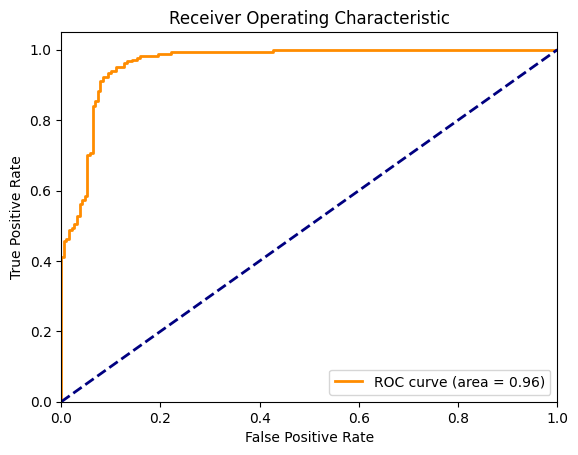

In [19]:
prediction_prob = clf.predict_proba(X_test)
print('ROC AUC:', roc_auc_score(y_test, prediction_prob[:,1]))

# plot ROC curve
fpr, tpr, _ = roc_curve(y_test, prediction_prob[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_combined_dph' / 'roc_curve.png', dpi=300, bbox_inches='tight')
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_combined_dph' / 'roc_curve.pdf', dpi=300, bbox_inches='tight')
plt.show()

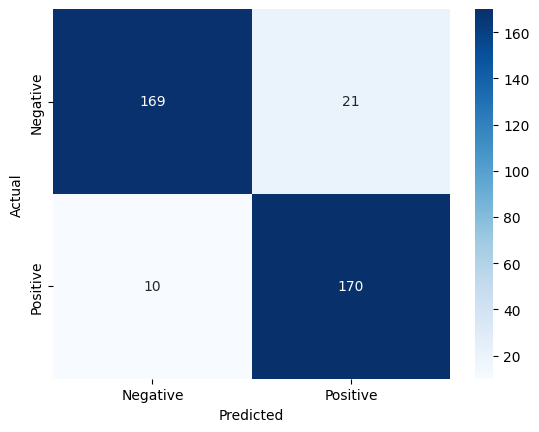

In [20]:
# plot confusion matrix
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_combined_dph' / 'confusion_matrix.png', dpi=500, bbox_inches='tight')
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_combined_dph' / 'confusion_matrix.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.89      0.92       190
           1       0.89      0.94      0.92       180

    accuracy                           0.92       370
   macro avg       0.92      0.92      0.92       370
weighted avg       0.92      0.92      0.92       370



In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, prediction_prob[:,1])
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {auc:.4f}')

Accuracy: 0.9162
Precision: 0.8901
Recall: 0.9444
F1 Score: 0.9164
ROC AUC: 0.9626


In [23]:
# print the prediction probabilities of the first 10 samples
print("Prediction probabilities of the first 10 samples:")
for i in range(20):
    print(f"Sample {i+1}: {prediction_prob[i]}")
# print the actual labels of the first 10 samples
print("Actual labels of the first 10 samples:")
for i in range(20):
    print(f"Sample {i+1}: {y_test[i]}")
# print the predicted labels of the first 10 samples
print("Predicted labels of the first 10 samples:")
for i in range(20):
    print(f"Sample {i+1}: {y_pred[i]}")


Prediction probabilities of the first 10 samples:
Sample 1: [0.89806324 0.10193678]
Sample 2: [0.9887074  0.01129256]
Sample 3: [0.9914629  0.00853709]
Sample 4: [0.98955446 0.01044553]
Sample 5: [0.28262696 0.717373  ]
Sample 6: [0.09869058 0.90130943]
Sample 7: [0.99113804 0.00886198]
Sample 8: [0.9966222  0.00337781]
Sample 9: [0.8784131  0.12158693]
Sample 10: [0.07844442 0.9215556 ]
Sample 11: [0.8938978  0.10610223]
Sample 12: [0.10961043 0.89038956]
Sample 13: [0.76891124 0.23108873]
Sample 14: [0.23957092 0.7604291 ]
Sample 15: [0.00312876 0.99687123]
Sample 16: [0.07638767 0.92361236]
Sample 17: [0.24198994 0.7580101 ]
Sample 18: [0.9932817  0.00671827]
Sample 19: [0.9927086 0.0072914]
Sample 20: [9.9979997e-01 2.0006155e-04]
Actual labels of the first 10 samples:
Sample 1: 0
Sample 2: 0
Sample 3: 0
Sample 4: 0
Sample 5: 1
Sample 6: 1
Sample 7: 0
Sample 8: 0
Sample 9: 0
Sample 10: 1
Sample 11: 0
Sample 12: 1
Sample 13: 0
Sample 14: 1
Sample 15: 1
Sample 16: 1
Sample 17: 0
Samp

### comparison with other baseline models

In [ ]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor
# from catboost import CatBoostClassifier, CatBoostRegressor

In [ ]:
mlp = keras.models.load_model(here() / config.model_dl / 'hpd_auc_91_acc_84_loss_51_gp.keras')

In [ ]:
# Define models
models = [
    ('TabPFN', tbp(random_state=42)),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    # ('MLP', mlp),
]

# Calculate scores
scoring = 'roc_auc_ovr' if len(np.unique(y)) > 2 else 'roc_auc'
scores = {name: cross_val_score(model, X_train, y_train, cv=5, scoring=scoring, n_jobs=1, verbose=1).mean()
          for name, model in models}

# Plot results
df = pd.DataFrame(list(scores.items()), columns=['Model', 'ROC AUC'])
ax = df.plot(x='Model', y='ROC AUC', kind='bar', figsize=(10, 6))
ax.set_ylim(df['ROC AUC'].min() * 0.995, min(1.0, df['ROC AUC'].max() * 1.005))
plt.grid(axis='y', linestyle='--')
# add numbers on top of the bars
for i, v in enumerate(df['ROC AUC']):
    ax.text(i, v + 0.005, f"{v:.3f}", ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.tight_layout()
ax.set_title('Model Comparison - 5-fold Cross-validation')

#### Shap explaination of the model

In [ ]:
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

In [ ]:
# # we will reset the model to less training data because we are on CPU
# if device == torch.device("cpu"):
#     print("Resetting the model to less training data:", X_train.shape[0])
#     x_train, y_train = X_train[:50], y_train[:50]
#     clf.fit(x_train, y_train)

In [ ]:
# print shape of label and x
print("Shape of y_train:", y_train.shape)
print("Shape of X_train:", X_train.shape)

In [ ]:
X

In [ ]:
x_explain = X.values
y_explain = y.values

prediction = clf.predict(x_explain)
print("Prediction: ", prediction)
print("True value: ", y_explain)


In [ ]:
explainer = shapiq.Explainer(
    model=clf,
    data=X_train,
    labels=y_train,
    index="SV",  # Shapley values
    max_order=1,  # first order Shapley values # Optional, can also be inferred from the model
)
print(f"Explainer Class: {explainer.__class__.__name__} inferred from the model.")

In [ ]:
from pathlib import Path

In [ ]:
print(tabpfn.__version__)

In [ ]:
imputer = explainer.imputer
if not Path("tabpfn_values_explainer.npz").exists():
    imputer.verbose = True  # see the pre-computation progress
    imputer.fit(x_explain)
    imputer.precompute()
    imputer.save_values("tabpfn_values_explainer.npz")
imputer.load_values("tabpfn_values_explainer.npz")

In [ ]:
feature_names = X.columns

In [ ]:
# shapley_values = explainer.explain(x_explain, budget=256)
# display(shapley_values.dict_values)
# shapley_values.plot_force(feature_names=feature_names)

In [ ]:
shapley_values = explainer.explain(x_explain, budget=256)

In [ ]:
display(shapley_values.dict_values)
shapley_values.plot_force(feature_names=feature_names)

In [ ]:
# plot and save the force plot
shapley_values.plot_force(feature_names=feature_names)
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_combined_dph' / 'force_plot.png', dpi=300, bbox_inches='tight')
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_combined_dph' / 'force_plot.pdf', dpi=300, bbox_inches='tight')

In [ ]:
shapley_values.plot_waterfall(feature_names=feature_names, max_display=12)
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_combined_dph' / 'force_plot.png', dpi=300, bbox_inches='tight')
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_combined_dph' / 'force_plot.pdf', dpi=300, bbox_inches='tight')

In [ ]:
shapley_values.plot_stacked_bar(feature_names=feature_names)

# explain the model

In [24]:
from sklearn.datasets import fetch_openml, load_breast_cancer
from tabpfn_extensions import interpretability
from tabpfn import TabPFNClassifier

# Access SHAP via interpretability.shap, not direct import



In [25]:
feature_names = X.columns.tolist()

In [26]:

n_samples = 200

# Calculate SHAP values
shap_values = interpretability.shap.get_shap_values(
    estimator=clf,
    # select random samples for SHAP calculation
    test_x=X_test[:n_samples],
    attribute_names=feature_names,
    algorithm="permutation",  # or "auto" for automatic selection
)


PermutationExplainer explainer: 201it [44:59:38, 809.89s/it]                             


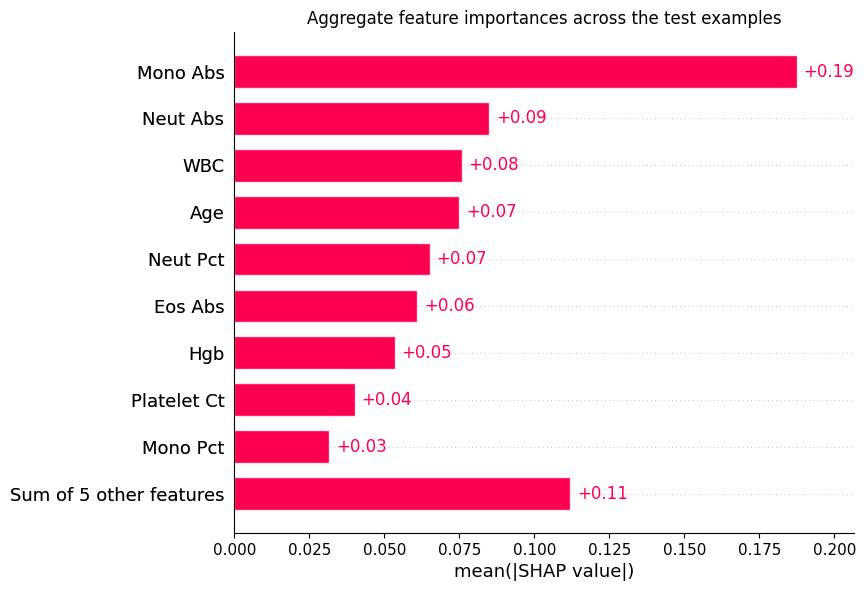

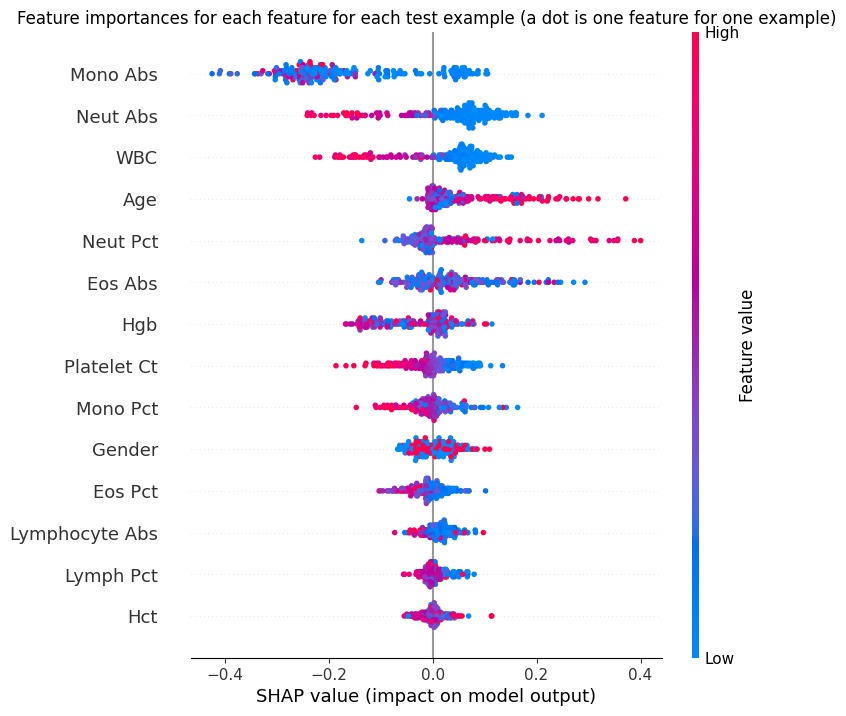

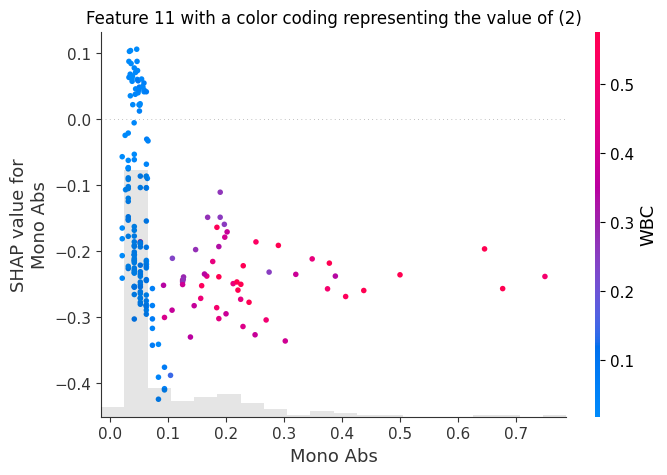

In [27]:
interpretability.shap.plot_shap(shap_values)

In [68]:
print(explainer.expected_value)

NameError: name 'explainer' is not defined

In [28]:
# save shap values to a file
out = here() / config.data_interim / 'shap_values_dipersio_trimmed_tabpfn.npz'
np.savez(
    out,
    values=shap_values.values,
    base_values=shap_values.base_values,
    data=shap_values.data
)
print("saved to", out)

saved to c:\workspace_dl\data\interim\shap_values_dipersio_trimmed_tabpfn.npz
